In [ ]:
from imutils.object_detection import non_max_suppression
import numpy as np
import cv2

def EAST_text_detector(original, image, confidence=0.25):
    # Set the new width and height and determine the changed ratio
    (h, W) = image.shape[:2]
    (newW, newH) = (1024, 2048)
    rW = W / float(newW)
    rH = h / float(newH)

    # Resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (h, W) = image.shape[:2]

    # Define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    net = cv2.dnn.readNet('frozen_east_text_detection.pb')

    # Construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, h), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)

    # Grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # Loop over the number of rows
    for y in range(0, numRows):
        # Extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # Loop over the number of columns
        for x in range(0, numCols):
            # If our score does not have sufficient probability, ignore it
            if scoresData[x] < confidence:
                continue

            # Compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # Extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # Use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # Compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # Add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # Apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    # Loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # Scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)

        # Draw the bounding box on the image
        cv2.rectangle(original, (startX, startY), (endX, endY), (36, 255, 12), 2)
    return original

# Convert to grayscale and Otsu's threshold
image = cv2.imread('demo/img/demo2.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
clean = thresh.copy()

# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,1))
detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(clean, [c], -1, 0, 3)

# Remove vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,30))
detect_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(clean, [c], -1, 0, 3)

# Remove non-text contours (curves, diagonals, circlar shapes)
cnts = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area > 1500:
        cv2.drawContours(clean, [c], -1, 0, -1)
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    x,y,w,h = cv2.boundingRect(c)
    if len(approx) == 4:
        cv2.rectangle(clean, (x, y), (x + w, y + h), 0, -1)

# Bitwise-and with original image to remove contours
filtered = cv2.bitwise_and(image, image, mask=clean)
filtered[clean==0] = (255,255,255)

# Perform EAST text detection
result = EAST_text_detector(image, filtered)

cv2.imshow('filtered', filtered)
cv2.imshow('result', result)
cv2.waitKey()

In [1]:
import numpy as np
import pdf2image
import cv2


In [2]:
def convert_pdf_to_image(document, dpi):
    images = []
    images.extend(
                    list(
                        map(
                            lambda image: cv2.cvtColor(
                                np.asarray(image), code=cv2.COLOR_RGB2BGR
                            ),
                            pdf2image.convert_from_path(document, dpi=dpi),
                        )
                    )
                )
    return images

In [3]:
images = convert_pdf_to_image('example1.pdf',300)

In [4]:
print(len(images))

1


In [5]:
print(images[0].shape)

(3508, 2481, 3)


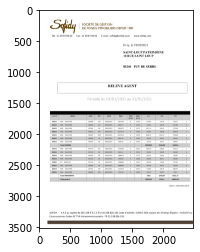

In [8]:
import matplotlib.pyplot as plt
first_page = images[0]
plt.imshow(first_page)

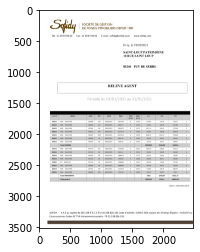

In [9]:
gray = cv2.cvtColor(first_page, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50,150,apertureSize = 3)
plt.imshow(first_page)

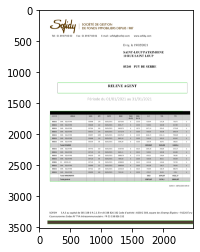

In [10]:
from scipy.spatial import distance
minLineLength = 100 # Min length of line. Line segments shorter than this are rejected.
maxLineGap = 10 # Maximum allowed gap between line segments to treat them as single line.
lines = cv2.HoughLinesP(edges,1,np.pi/180,200, minLineLength,maxLineGap)
for line in lines:
    for x1,y1,x2,y2 in line:
        if distance.euclidean((x1,y1), (x2,y2)) > 600:
            cv2.line(first_page ,(x1,y1),(x2,y2),(0,255,0),2)
plt.imshow(first_page)

In [11]:
def detect_orientation(all_lines):
    vertical = []
    horizontal = []
    for line in all_lines:
        for x1,y1,x2,y2 in line:
            if distance.euclidean((x1,y1), (x2,y2)) > 600:
                if x1 == x2:
                    vertical.append(line)
                elif y1 == y2:
                    horizontal.append(line)
    return vertical, horizontal

v, h = detect_orientation(lines)

In [12]:
x = sorted([value[0,0] for value in v]) # create a list with all the x values in the vertical lines
y = sorted([value[0,1] for value in h]) # create a list with all the y values in the horizontal lines

x_min, x_max = x[-2], x[-1] 
y_min, y_max = y[0], y[-1]

plt.imshow(first_page[ y_min:y_max, x_min:x_max])

IndexError: list index out of range

In [89]:
import pytesseract
document_text = pytesseract.image_to_string(first_page[ y_min:y_max, x_min:x_max])
for line in document_text.split('\n'):
    print(line)

SAINT LOUP PATRIMOINE |

' Code apporteur: 850526

 

nplement de commissionnement sur UC Période du: 01/01/2021 au 31/01/2021

Libellé Support Assiette de calcul * | Taux quotidien | Taux Annuel Comission
(%) complémentaire

i

    
   
  

  
 
 
 
  

Total AVIP MULTILIB 1 349 477,51€ i Ta 22,24 €

      
 
    

   
    
     

 

 



In [91]:
import pandas as pd
df = pytesseract.image_to_data(first_page[ y_min:y_max, x_min:x_max], output_type=pytesseract.Output.DATAFRAME).dropna()
df.head(10)

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
4,5,1,1,1,1,1,1272,28,108,29,92.631767,SAINT
5,5,1,1,1,1,2,1393,28,98,28,90.079353,LOUP
6,5,1,1,1,1,3,1506,27,227,29,90.079353,PATRIMOINE
7,5,1,1,1,1,4,1965,18,1,21,81.206779,|
11,5,1,2,1,1,1,1257,162,1,6,30.518661,'
12,5,1,2,1,1,2,1290,159,106,34,92.810417,Code
13,5,1,2,1,1,3,1412,160,205,41,91.376686,apporteur:
14,5,1,2,1,1,4,1651,158,149,35,96.825180,850526
18,5,1,3,1,1,1,1257,235,125,3,95.000000,
22,5,1,4,1,1,1,0,293,188,43,52.552647,nplement
